In [24]:
%%HTML
<style>
    body {
        --vscode-font-family: "ComicSansMS"
    }
</style>

## LDO Analysis for C/ID

In [25]:
import numpy as np

In [26]:
## Design requirements
kT = 1.38e-23 * 300 # Boltzmann constant times temperature in Kelvin
Gamma = 2/3
PSRR_dB = -60
V_ctrl = 0.9
V_dd = 1.8
V_out = 1.2
f_bw = 1e6
I_load = 1e-3
PM_target = 60 # degrees
Noise_target = 250e-6 # Integrated noise target

In [27]:
## Determining Gain requirements of the Amplifier in feedback

Amp_gain_target = (10**(-1*PSRR_dB/20)) * (V_out / V_ctrl)
Amp_gain_target_dB = 20 * np.log10(Amp_gain_target)
print("Target Gain of the Amplifier in feedback: ", Amp_gain_target)
print("Target Gain of the Amplifier in feedback (dB): ", Amp_gain_target_dB)

Target Gain of the Amplifier in feedback:  1333.3333333333333
Target Gain of the Amplifier in feedback (dB):  62.498774732166


In [28]:
## Bandwidth estimation

C_L = 1.5e-12 # Load capacitance - starting value can change later if noise requirements are not met

## Assuming dominant pole comes from the main circuit
R_eff = 1/(f_bw * 2 * np.pi * C_L)
print("Effective Resistance seen by the load capacitance: ", R_eff)

I_total = (V_out / R_eff) + I_load
print("Total Current flowing through the lPMOS: ", I_total*1e3, "mA")

print("Overhead of the LDO: ", (I_total - I_load)*1e3, "mA")
print("overhead percentage of the LDO: ", ((I_total - I_load) / I_total) * 100, "%")

Effective Resistance seen by the load capacitance:  106103.29539459689
Total Current flowing through the lPMOS:  1.0113097335529233 mA
Overhead of the LDO:  0.011309733552923194 mA
overhead percentage of the LDO:  1.1183253930712158 %


In [29]:
## Amplifier bandwidth estimation
factor = np.tan(PM_target * np.pi / 180) # Converting PM to radians
factor = np.ceil(factor)
print("Bandwidth factor due to PM requirements: ", factor,"x")
Amp_bw = f_bw * factor # Assuming 10 times the bandwidth of the system

print("Target Bandwidth of the Amplifier: ", Amp_bw*1e-6, "MHz")

GBW_Amp = Amp_gain_target * Amp_bw
print("Gain-Bandwidth Product of the Amplifier: ", GBW_Amp*1e-9, "GHz")

Bandwidth factor due to PM requirements:  2.0 x
Target Bandwidth of the Amplifier:  2.0 MHz
Gain-Bandwidth Product of the Amplifier:  2.6666666666666665 GHz


In [30]:
## Noise estimation
Noise_bandwidth = 5*f_bw # Assuming a 2nd order system
PSD_target = Noise_target**2 / (f_bw) # Assuming uniform distribution of noise over the bandwidth
print("Power Spectral Density target: ", PSD_target, "V^2/Hz")

## Assume equal noise contribution from amp and non-amp
V_noise_amp = Noise_target / np.sqrt(2)
V_noise_LDO = Noise_target / np.sqrt(2)

V_noise_amp_input = V_noise_amp / (Amp_gain_target)

print("Target output referred noise contribution from Amp: ", V_noise_amp*1e6, "uV")
print("Target input referred noise contribution from Amp: ", V_noise_amp_input*1e6, "uV")

V_noise_Reff = np.sqrt((4*kT*R_eff)*Noise_bandwidth)
print("R_eff noise contribution: ", V_noise_Reff*1e6, "uV")

V_noise_PMOS_target = np.sqrt((V_noise_LDO**2) - (V_noise_Reff**2))
print("PMOS noise target: ", V_noise_PMOS_target*1e6, "uV")
PSD_PMOS_target = V_noise_PMOS_target**2 / Noise_bandwidth
gm_PMOS_target = PSD_PMOS_target/(4*kT*(R_eff**2))
print("Target gm of the pass transistor: ", gm_PMOS_target*1e3, "mS")

gm_ID_target = gm_PMOS_target / (I_total)
print("kgm target of the pass transistor: ", gm_ID_target)

Power Spectral Density target:  6.25e-14 V^2/Hz
Target output referred noise contribution from Amp:  176.7766952966369 uV
Target input referred noise contribution from Amp:  0.13258252147247768 uV
R_eff noise contribution:  93.73021315815207 uV
PMOS noise target:  149.8821108115554 uV
Target gm of the pass transistor:  0.024099693510322186 mS
kgm target of the pass transistor:  0.023830180518143916


In [31]:
## Amplifier requirements
print("\n\nSummary of the Amplifier requirements:")
print("Gain: ", Amp_gain_target, " (", Amp_gain_target_dB, "dB )")
print("Input referred noise: ", V_noise_amp_input*1e6, "uV")
print("Bandwidth: ", Amp_bw*1e-6, "MHz")




Summary of the Amplifier requirements:
Gain:  1333.3333333333333  ( 62.498774732166 dB )
Input referred noise:  0.13258252147247768 uV
Bandwidth:  2.0 MHz


In [32]:
## gm requirements estimation based on bandwidth for a single stage amp

Cgs_pmos = 100e-12
C_par_amp = 50e-12

C_Load_1 = Cgs_pmos + C_par_amp

gm_target_bw =  (2 * np.pi * Amp_bw * C_Load_1)
print("Minimum gm requirement of the amplifier for the given bandwidth: ", gm_target_bw*1e3, "mS")

Minimum gm requirement of the amplifier for the given bandwidth:  1.8849555921538759 mS


In [33]:
## gm requirements estimation based on noise requirements for a single stage amp

Noise_bandwidth_amp = 5*Amp_bw

PSD_target_amp = (V_noise_amp**2) / Noise_bandwidth_amp

gm_target_noise = 4*kT*Gamma / PSD_target_amp

print("Minimum gm requirement of the amplifier for the given noise target: ", gm_target_noise*1e3, "mS")

Minimum gm requirement of the amplifier for the given noise target:  0.003532800000000001 mS


In [34]:
## gm requirements for design
gm_target = max(gm_target_bw, gm_target_noise)
print("Minimum gm requirement of the amplifier for the given design: ", gm_target*1e3, "mS")

Minimum gm requirement of the amplifier for the given design:  1.8849555921538759 mS


## Updated estimate om Sep 06 2025

In [35]:
C_load_eff = 100.4e-12 # Effective load capacitance including parasitics from previous analysis

R_L_eff = 290 # Effective load resistance including pass transistor rds from previous analysis

## Bandwidth target and Reff estimate
BW_target = 1e6  # 2MHz

f_bw = 1/(2 * np.pi * R_L_eff * C_load_eff)
print(f"Achieved Bandwidth with R_L_eff {R_L_eff:.2f} Ohms and C_load_eff {C_load_eff*1e12:.1f} pF: {f_bw*1e-6:.2f} MHz")

C_scale = f_bw / BW_target
print(f"Capacitance scaling factor to achieve target BW {BW_target*1e-6:.1f} MHz: {C_scale:.3f}x")


Achieved Bandwidth with R_L_eff 290.00 Ohms and C_load_eff 100.4 pF: 5.47 MHz
Capacitance scaling factor to achieve target BW 1.0 MHz: 5.466x


# Reestimating pole requriements for the design on Sep 06 2025

In [36]:
f_bw = 1e6
Ao = 1000 # 60dB
PM_target = 60 # degrees

f_u = f_bw * Ao
print(f"Unity Gain Frequency (f_u) of the Amplifier for BW target {f_bw*1e-6:.1f} MHz and Gain {Ao} (60dB): {f_u*1e-6:.2f} MHz")

f_p2 = f_u*np.tan(np.radians(PM_target))
print(f"Required location of the 2nd pole (f_p2) for PM target {PM_target} degrees: {f_p2*1e-6:.2f} MHz")

f_p3 = f_p2 * 2
print(f"Required location of the 3rd pole (f_p3) for stability: {f_p3*1e-6:.2f} MHz")


Unity Gain Frequency (f_u) of the Amplifier for BW target 1.0 MHz and Gain 1000 (60dB): 1000.00 MHz
Required location of the 2nd pole (f_p2) for PM target 60 degrees: 1732.05 MHz
Required location of the 3rd pole (f_p3) for stability: 3464.10 MHz


In [37]:
## Estimating circuit paramters for f_p3 for a source follower stage
C_load = 11.4e-12
R_eff = 1/(2 * np.pi * f_p3 * C_load)
print(f"Effective Resistance (R_eff) seen by the load capacitance {C_load*1e12:.1f} pF for f_p3 {f_p3*1e-6:.2f} MHz: {R_eff:.2f} Ohms")

Effective Resistance (R_eff) seen by the load capacitance 11.4 pF for f_p3 3464.10 MHz: 4.03 Ohms


## LDO High level Optimization strategy
1. Bandwidth
2. Power budget
3. PSRR
4. Slewing 

In [38]:
## Amplifer design parameters based on pass transistor design targets
C_load = 11.4e-12 # Comes from the pass transistor design
f_bw = 1e6
k = 3/4 # 0.9V ctrl voltage and 1.2V LDO output voltage
I_load = 10e-3 # LDO load current through the pass transistor
Av_pass = 25 # Gain of the pass transistor stage

In [39]:
## 1st case, 10% of I_load and 60 dB PSRR
PSRR_target_dB = -60
PSRR_target = 10**(PSRR_target_dB/20)
I_budget = (10/100) * I_load
Av_amp = (10**(-PSRR_target_dB/20)) * (1/(k*Av_pass))
print(f"Amplifier Gain (Av_amp) requirement for {I_budget*1e3:.1f} mA budget and 60 dB PSRR: {Av_amp:.2f} V/V")

Amplifier Gain (Av_amp) requirement for 1.0 mA budget and 60 dB PSRR: 53.33 V/V


In [40]:
## Pole requirements for stability
f_u = (1/PSRR_target)*f_bw
f_p2 = f_u * np.tan(np.radians(PM_target))
f_p3 = f_p2 * 2

print(f"Unity Gain Frequency (f_u) of the Amplifier for BW target {f_bw*1e-6:.1f} MHz and PSRR target {PSRR_target_dB} dB: {f_u*1e-6:.2f} MHz")
print(f"Required location of the 2nd pole (f_p2) for PM target {PM_target} degrees: {f_p2*1e-6:.2f} MHz")
print(f"Required location of the 3rd pole (f_p3) for stability: {f_p3*1e-6:.2f} MHz")

Unity Gain Frequency (f_u) of the Amplifier for BW target 1.0 MHz and PSRR target -60 dB: 1000.00 MHz
Required location of the 2nd pole (f_p2) for PM target 60 degrees: 1732.05 MHz
Required location of the 3rd pole (f_p3) for stability: 3464.10 MHz


In [41]:
## Assuming first stage dominant pole and second stage of amp is a source follower
Av_2 = 1 # Gain of the 2nd stage of the amplifier
Av_1 = Av_amp / Av_2

In [42]:
GBW_stage1 = Av_1 * f_p2
GBW_stage2 = Av_2 * f_p3

print(f"Gain-Bandwidth Product of stage 1 (GBW_stage1) with Av_1 {Av_1:.2f} and f_p2 {f_p2*1e-6:.2f} MHz: {GBW_stage1*1e-9:.2f} GHz")
print(f"Gain-Bandwidth Product of stage 2 (GBW_stage2) with Av_2 {Av_2:.2f} and f_p3 {f_p3*1e-6:.2f} MHz: {GBW_stage2*1e-9:.2f} GHz")

Gain-Bandwidth Product of stage 1 (GBW_stage1) with Av_1 53.33 and f_p2 1732.05 MHz: 92.38 GHz
Gain-Bandwidth Product of stage 2 (GBW_stage2) with Av_2 1.00 and f_p3 3464.10 MHz: 3.46 GHz


In [43]:
## Checking second stage GBW feasibility
kgm_max = 25 # Arbitrary max value for 180nm technology
gm_req = 2 * np.pi * C_load * GBW_stage2 
I_req = gm_req / kgm_max
print(f"Required gm of the 2nd stage of the amplifier for GBW_stage2 {GBW_stage2*1e-9:.2f} GHz and C_load {C_load*1e12:.1f} pF: {gm_req*1e3:.2f} mS")
print(f"Required current of the 2nd stage of the amplifier for kgm_max {kgm_max} : {I_req*1e3:.2f} mA")

Required gm of the 2nd stage of the amplifier for GBW_stage2 3.46 GHz and C_load 11.4 pF: 248.13 mS
Required current of the 2nd stage of the amplifier for kgm_max 25 : 9.93 mA


In [44]:
## Converting this into a function for varying PSRR and I_budget just for the second stage
def analyze_second_stage(PSRR_target_dB, I_budget):
    PSRR_target = 10**(PSRR_target_dB/20)
    f_u = (1/PSRR_target)*f_bw
    f_p2 = f_u * np.tan(np.radians(PM_target))
    f_p3 = f_p2 * 2

    GBW_stage2 = Av_2 * f_p3

    kgm_max = 25 # Arbitrary max value for 180nm technology
    gm_req = 2 * np.pi * C_load * GBW_stage2
    I_req = gm_req / kgm_max
    # print(f"Required gm of the 2nd stage of the amplifier for GBW_stage2 {GBW_stage2*1e-9:.2f} GHz and C_load {C_load*1e12:.1f} pF: {gm_req*1e3:.2f} mS")
    # print(f"Required current of the 2nd stage of the amplifier for kgm_max {kgm_max} : {I_req*1e3:.2f} mA while having I_budget {I_budget*1e3:.1f} mA and PSRR_target {PSRR_target_dB} dB")
    return I_req

I_req_2 = analyze_second_stage(-35, (5/100)*I_load)

Closest I_req_2 to I_budget: 0.4974 mA at PSRR = -34 dB


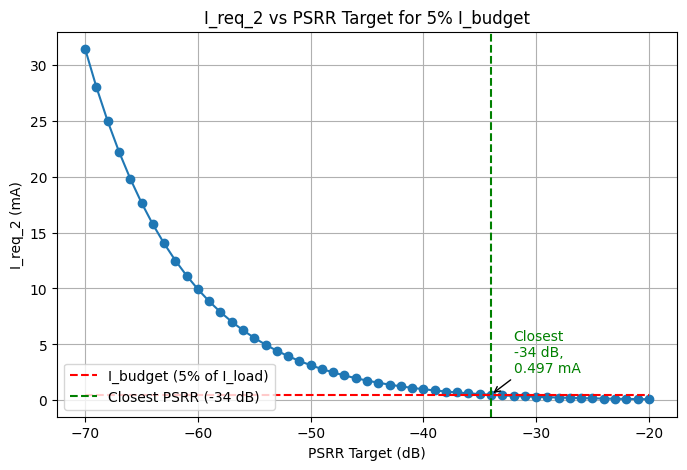

In [45]:
import matplotlib.pyplot as plt

PSRR_targets_dB = np.arange(-70, -19, 1)
I_budget = 0.05 * I_load
I_req_2_list = []

for psrr_db in PSRR_targets_dB:
    I_req_2_list.append(analyze_second_stage(psrr_db, I_budget))


I_req_2_arr = np.array(I_req_2_list)
idx_closest = np.argmin(np.abs(I_req_2_arr - I_budget))
i_req_closest = I_req_2_arr[idx_closest]
psrr_closest = PSRR_targets_dB[idx_closest]
print(f"Closest I_req_2 to I_budget: {i_req_closest*1e3:.4f} mA at PSRR = {psrr_closest} dB")



plt.figure(figsize=(8,5))
plt.plot(PSRR_targets_dB, np.array(I_req_2_list)*1e3, marker='o')
plt.hlines(I_budget*1e3, PSRR_targets_dB[0], PSRR_targets_dB[-1], color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.axvline(psrr_closest, color='g', linestyle='--', label=f'Closest PSRR ({psrr_closest} dB)')
plt.annotate(f'Closest\n{psrr_closest} dB,\n{(i_req_closest*1e3):.3f} mA',
             xy=(psrr_closest, i_req_closest*1e3),
             xytext=(psrr_closest+2, i_req_closest*1e3+2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='g')
plt.legend()
plt.xlabel('PSRR Target (dB)')
plt.ylabel('I_req_2 (mA)')
plt.title('I_req_2 vs PSRR Target for 5% I_budget')
plt.grid(True)
plt.show()

## Next steps 
1. Extract Kgm vs kcg data for a source follower by sweeping the current.
2. Large signal needs to be captured since V_g of PMOS needs to be close to 1.25V 